# Assignment 2

Demostrate consequences of No Free Lunch Theorem: every model of machine learning makes **assumptions** about dataset properties. If the assumption fails, model perfoms badly. If the assumption is met, model perfoms good.

For each of the tasks, described below:
1. create a dataset to meet the description. For demonstration purposes, feature dimension size = 2    
1. train the models and evaluate accuracy. (with a training pipeline, described in the seminar) 
1. Show which model is better.   
1. Write what assumptions were used, and why model exibits such behavior.  
1. Plot dataset to demonstrate its properties. (Scatter plot, classes with different colors)  


Tasks:

1. Create dataset for binary classification task (binary crossentropy), 
where k-NN perfoms **worse** than logistic regression

2. Create dataset for binary classification task (binary crossentropy), 
where logistic regression perfoms **worse** than k-NN

3. Create dataset for binary classification task (binary crossentropy), 
where k-NN with cosine distance perfoms **better** than k-NN with euclidean distance


! If there is no explanation, why one model perfoms better than the other on your dataset, the task does not count.  
! if the training pipeline is not used, the task does not count.  

##### Common functions

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_classification, load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

In [2]:
def draw_line(a, b, c, ax):
    """
    Draw line a*x + b*y + c = 0
    """
    if a == 0 and b == 0:
        raise ValueError('Incorrect arguments')
    if b == 0:
        ax.vlines(-c / a, *ax.get_ylim())
    else:
        x = np.array(ax.get_xlim())
        y = -(a * x + c) / b
        ax.plot(x, y)

In [3]:
def create_scatter_plot(X, y_true, y_pred=None, colors=('red', 'blue'), labels=('first class', 'second class'), a=None, b=None, c=None):
    """
    a scatter plot for binary classification task
    draws a line if a, b, c are specified
    """
    fig, ax = plt.subplots()
    ax.scatter(X[y_true == 0][:, 0], X[y_true == 0][:, 1], c=colors[0], label=labels[0], alpha=0.5)
    ax.scatter(X[y_true == 1][:, 0], X[y_true == 1][:, 1], c=colors[1], label=labels[1], alpha=0.5)
    if y_pred is not None:
        ax.scatter(X[y_pred == 0][:, 0], X[y_pred == 0][:, 1], c=colors[0], alpha=0.5)
        ax.scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1], c=colors[1], alpha=0.5)
    if a is not None and b is not None and c is not None:
        draw_line(a, b, c, ax)
    tmp = plt.title('Scatter plot')
    plt.xlabel('first feature')
    plt.ylabel('second feature')
    plt.legend(loc='best', framealpha=0.25)
    plt.show()

##### Task 1

In [4]:
X, y = make_classification(n_samples=100, n_informative=2, n_redundant=0, n_features=2, n_classes=2, random_state=19)

In [5]:
# 80% - train, 20% - val, 20% - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=21)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))
ps = PredefinedSplit([-1] * len(X_train) + [0] * len(X_val))

In [6]:
# by default n_neighbors == 5
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)
print('val score:', kNN.score(X_val, y_val))
print('test score:', kNN.score(X_test, y_test))

val score: 0.95
test score: 0.85


In [7]:
param_grid = {'n_neighbors': np.arange(1, 25)}
kNN_grid = GridSearchCV(kNN, param_grid, cv=ps)
kNN_grid.fit(X_train_full, y_train_full)
print('best n_neighbors:', kNN_grid.best_params_['n_neighbors'])
print('best val score:', kNN_grid.best_score_)

best n_neighbors: 1
best val score: 1.0


In [8]:
kNN = KNeighborsClassifier(n_neighbors=kNN_grid.best_params_['n_neighbors'])
kNN.fit(X_train, y_train)
kNN_y_pred = kNN.predict(X_test)
print('val score:', kNN.score(X_val, y_val))
print('test score:', kNN.score(X_test, y_test))

val score: 1.0
test score: 0.85


In [9]:
logr = LogisticRegression(random_state=21)
logr.fit(X_train, y_train)
print('val score:', logr.score(X_val, y_val))
print('test score:', logr.score(X_test, y_test))

val score: 0.95
test score: 0.9


In [10]:
logr.coef_, logr.intercept_

(array([[ 2.2921708 , -0.12922496]]), array([0.51605053]))

In [11]:
# Note that regularization is applied by default. (c) docs
param_grid = {'penalty': ['l1', 'l2', 'none'], 'solver': ['newton-cg', 'saga', 'liblinear', 'sag', 'lbfgs'], 'max_iter': np.arange(50, 500, 50)}
logr_grid = GridSearchCV(logr, param_grid, cv=ps, error_score=-np.Inf)
logr_grid.fit(X_train_full, y_train_full)
print('best penalty:', logr_grid.best_params_['penalty'])
print('best solver:', logr_grid.best_params_['solver'])
print('best max_iter:', logr_grid.best_params_['max_iter'])
print('best val score:', logr_grid.best_score_)

best penalty: l1
best solver: saga
best max_iter: 50
best val score: 0.95


In [12]:
logr = LogisticRegression(random_state=21, penalty=logr_grid.best_params_['penalty'],
    solver=logr_grid.best_params_['solver'], max_iter=logr_grid.best_params_['max_iter'])
logr.fit(X_train, y_train)
print('val score:', logr.score(X_val, y_val))
print('test score:', logr.score(X_test, y_test))

val score: 0.95
test score: 0.9


In [13]:
coefs = logr.coef_[0]
intercept = logr.intercept_

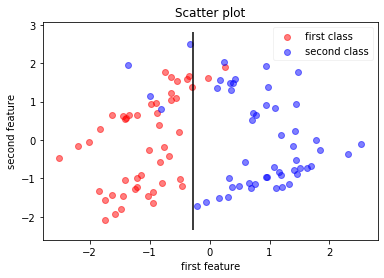

In [14]:
create_scatter_plot(X, y, a=coefs[0], b=coefs[1], c=intercept)

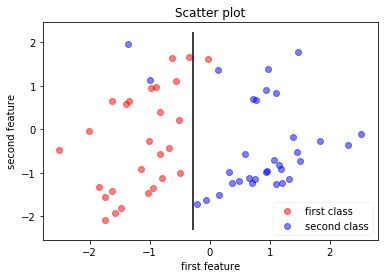

In [15]:
create_scatter_plot(X_train, y_train, a=coefs[0], b=coefs[1], c=intercept)

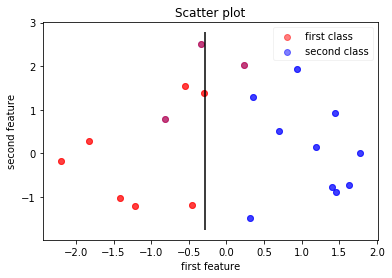

In [16]:
create_scatter_plot(X_test, y_test, y_pred=kNN_y_pred, a=coefs[0], b=coefs[1], c=intercept)

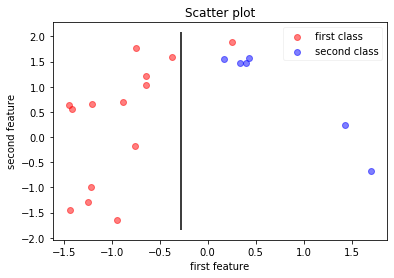

In [17]:
create_scatter_plot(X_val, y_val, a=coefs[0], b=coefs[1], c=intercept)

В силу того, что валидационная выборка, по которой мы подбираем параметр `n_neighbors` (количество ближайших соседей, на класс которых мы смотрим при определении класса конкретного объекта), получилась не очень похожей на тестовую выборку, было выбрано не самое оптимальное значение `n_neighbours` == 1, т.е. класс объекта определяется классом самого ближайшего соседа, что, как видно на графике тестовых данных, даст три некорректно атрибутированных объекта (как раз 0.15: см. фиолетовые точки на графике). В то же время при другом количестве ближайших соседей (а именно 15, см. ниже), результат даже лучше, чем в логистической регрессии.

В логистической регрессии была подобрана вертикальная прямая, которая, как видно из графика с тестовыми данными, неверно относит лишь два объекта.

Ограничение kNN: kNN будет вести себя плохо, если данные не скучкованы и/или перемешаны.
Ограничение логистической регрессии: предсказывает прямую, поэтому если данные явно не разделяются прямой, то качество будет плохим. Особенно плохим будет качество для "нелинейных" датасетов (например, точки дублируют какую-нибудь кривую).

In [18]:
kNN = KNeighborsClassifier(n_neighbors=15)
kNN.fit(X_train, y_train)
kNN_y_pred = kNN.predict(X_test)
print('val score:', kNN.score(X_val, y_val))
print('test score:', kNN.score(X_test, y_test))

val score: 0.95
test score: 0.95


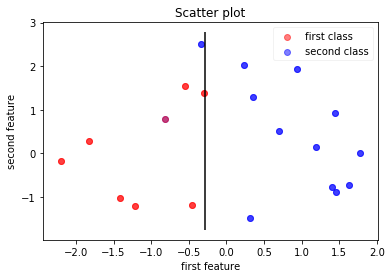

In [19]:
# здесь некорректно атрибутирован только центральный синий объект, который и правда там не очень уместен.
create_scatter_plot(X_test, y_test, y_pred=kNN_y_pred, a=coefs[0], b=coefs[1], c=intercept)

##### Task 2

In [20]:
X, y = make_classification(n_samples=100, n_informative=2, n_redundant=0, n_features=2, n_classes=2, random_state=32)

In [21]:
# 80% - train, 20% - val, 20% - test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=21)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))
ps = PredefinedSplit([-1] * len(X_train) + [0] * len(X_val))

In [22]:
# by default n_neighbors == 5
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)
print('val score:', kNN.score(X_val, y_val))
print('test score:', kNN.score(X_test, y_test))

val score: 0.85
test score: 0.95


In [23]:
param_grid = {'n_neighbors': np.arange(1, 25)}
kNN_grid = GridSearchCV(kNN, param_grid, cv=ps)
kNN_grid.fit(X_train_full, y_train_full)
print('best n_neighbors:', kNN_grid.best_params_['n_neighbors'])
print('best val score:', kNN_grid.best_score_)

best n_neighbors: 3
best val score: 1.0


In [24]:
kNN = KNeighborsClassifier(n_neighbors=kNN_grid.best_params_['n_neighbors'])
kNN.fit(X_train, y_train)
kNN_y_pred = kNN.predict(X_test)
print('val score:', kNN.score(X_val, y_val))
print('test score:', kNN.score(X_test, y_test))

val score: 1.0
test score: 0.95


In [25]:
logr = LogisticRegression(random_state=21)
logr.fit(X_train, y_train)
print('val score:', logr.score(X_val, y_val))
print('test score:', logr.score(X_test, y_test))

val score: 0.8
test score: 0.85


In [26]:
# Note that regularization is applied by default. (c) docs
param_grid = {'penalty': ['l1', 'l2', 'none'], 'solver': ['newton-cg', 'saga', 'liblinear', 'sag', 'lbfgs'], 'max_iter': np.arange(50, 500, 50)}
logr_grid = GridSearchCV(logr, param_grid, cv=ps, error_score=-np.Inf)
logr_grid.fit(X_train_full, y_train_full)
print('best penalty:', logr_grid.best_params_['penalty'])
print('best solver:', logr_grid.best_params_['solver'])
print('best max_iter:', logr_grid.best_params_['max_iter'])
print('best val score:', logr_grid.best_score_)

best penalty: l1
best solver: saga
best max_iter: 50
best val score: 0.8


In [27]:
logr = LogisticRegression(random_state=21, penalty=logr_grid.best_params_['penalty'],
    solver=logr_grid.best_params_['solver'], max_iter=logr_grid.best_params_['max_iter'])
logr.fit(X_train, y_train)
print('val score:', logr.score(X_val, y_val))
print('test score:', logr.score(X_test, y_test))

val score: 0.8
test score: 0.85


In [28]:
coefs = logr.coef_[0]
intercept = logr.intercept_

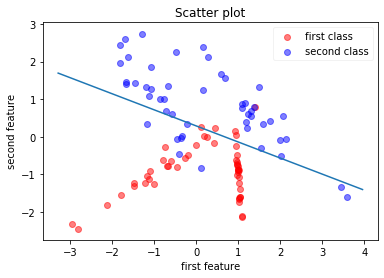

In [29]:
create_scatter_plot(X, y, a=coefs[0], b=coefs[1], c=intercept)

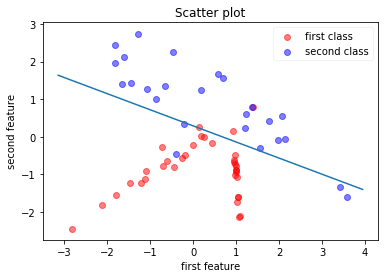

In [30]:
create_scatter_plot(X_train, y_train, a=coefs[0], b=coefs[1], c=intercept)

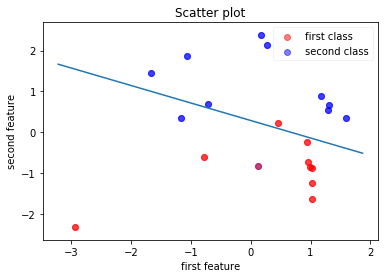

In [31]:
create_scatter_plot(X_test, y_test, y_pred=kNN_y_pred, a=coefs[0], b=coefs[1], c=intercept)

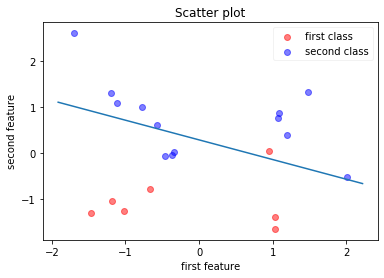

In [32]:
create_scatter_plot(X_val, y_val, a=coefs[0], b=coefs[1], c=intercept)

Несмотря на то, что логистическая регрессия классифицирует данные с помощью сигмоиды, предсказывает она прямую (хотя можно было бы добавить квадратичные признаки и тогда качество было бы лучше), поэтому в случае такого датасета, который нельзя безошибочно разделить на две группы прямой, но который довольно сильно сгруппирован по классам (см. график), лучше себя ведет kNN, поскольу этот алгоритм позволяет учитывать взаимную близость объектов.

Безусловно, имеет значение и особенность тестовых данных, где в случае kNN мы теряем только один объект (см. на графике центральный фиолетовый кружок). Уже количества ближайших соседей `n_neighbours` == 3 достаточно, чтобы отнести почти все объекты корректно.

##### Task 3

In [33]:
# без валидационной выборки, т.к. датасет маленький
X = np.array([
    [1, 1], [2, 2], [4, 4], [8, 8], [16, 16], [-1, -1], [-2, -2], [-4, -4], [-8, -8], [-16, -16],
    [-1, 1], [-2, 2], [-4, 4], [-8, 8], [-16, 16], [1, -1], [2, -2], [4, -4], [8, -8], [16, -16],
])
y = np.array([1] * 10 + [0] * 10)

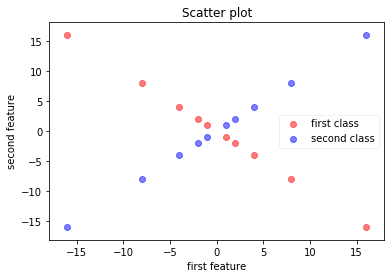

In [34]:
create_scatter_plot(X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

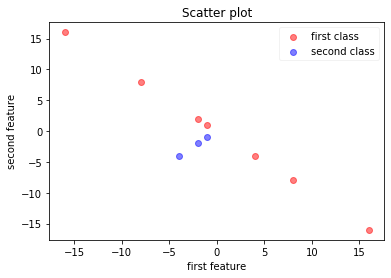

In [36]:
create_scatter_plot(X_test, y_test)

In [37]:
import sklearn
sorted(sklearn.neighbors.VALID_METRICS['brute'])

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'haversine',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'wminkowski',
 'yule']

In [38]:
# by default metric == 'minkowski'
kNN = KNeighborsClassifier(metric='euclidean')
kNN.fit(X_train, y_train)
print('test score:', kNN.score(X_test, y_test))

test score: 0.2


In [39]:
best_n_neighbors = 0
best_test_value = -1
for n_neighbors in range(1, 11):
    kNN = KNeighborsClassifier(metric='euclidean', n_neighbors=n_neighbors)
    kNN.fit(X_train, y_train)
    test_value = kNN.score(X_test, y_test)
    if test_value > best_test_value:
        best_test_value = test_value
        best_n_neighbors = n_neighbors
print('best n_neighbors:', best_n_neighbors)

best n_neighbors: 1


In [40]:
kNN = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric='euclidean')
kNN.fit(X_train, y_train)
kNN_y_pred_euclidean = kNN.predict(X_test)
print('test score:', kNN.score(X_test, y_test))

test score: 0.7


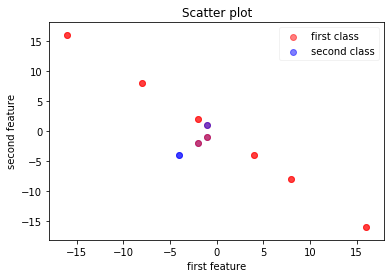

In [41]:
# Euclidean
create_scatter_plot(X_test, y_test, y_pred=kNN_y_pred_euclidean)

In [42]:
kNN = KNeighborsClassifier(metric='cosine')
kNN.fit(X_train, y_train)
print('test score:', kNN.score(X_test, y_test))

test score: 0.0


In [43]:
best_n_neighbors = 0
best_test_value = 0
for n_neighbors in range(1, 11):
    kNN = KNeighborsClassifier(metric='cosine', n_neighbors=n_neighbors)
    kNN.fit(X_train, y_train)
    test_value = kNN.score(X_test, y_test)
    if test_value > best_test_value:
        best_test_value = test_value
        best_n_neighbors = n_neighbors
print('best n_neighbors:', best_n_neighbors)

best n_neighbors: 1


In [44]:
kNN = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric='cosine')
kNN.fit(X_train, y_train)
kNN_y_pred_cosine = kNN.predict(X_test)
print('test score:', kNN.score(X_test, y_test))

test score: 1.0


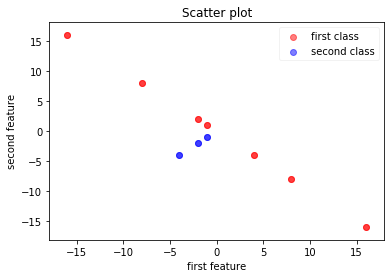

In [45]:
# Cosine
create_scatter_plot(X_test, y_test, y_pred=kNN_y_pred_cosine)

У точек, лежащих на одной прямой (, проходящей через центр координат), косинусная мера (по модулю) между ними равна единице, соответственно, независимо от евклидова расстояния между ними, они будут близкими по косинусной метрике. Но если точки, относящиеся к разным прямым, лежат рядом, то в алгоритме kNN с евклидовой метрикой они могут попасть в чужой класс, что и происходит (см. на графике Euclidean выше).

Это довольно вырожденный случай датасета, гораздо чаще евклидова мера даёт лучший результат. Косинусную меру имеет смысл использовать, когда нам важны пропорции и не очень важна "амплитуда" значений. Например, мы можем использовать косинусную метрику, если мы хотим сравнить тексты разной длины. Тогда два текста будут близки, если в них в одинаковой пропорции встречаются похожие слова. По евклидовой метрике в этом случае тексты могут сильно различаться.